<a href="https://colab.research.google.com/github/26medias/TF-Face-Angle-Translation/blob/master/Face_Position_Dataset_Builder_One_shot_per_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Angle Dataset Generator


## Credits

Face extraction built thanks to https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/

## How this works

1. Download movie trailers
2. Extract the frames from the video files
3. Extract the faces from the images
4. Cluster the faces by actor
5. Build & save the facial landmarks for each face
6. Build the dataset
7. Zip & upload the dataset to Google Storage

## Downloading videos, extracting the frames

We're going to download movie trailers from https://www.davestrailerpage.co.uk/

The frames from the video files will be extracted and saved to file.

## Code setup: Imports & methods

Pip install

In [1]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip show keras-vggface
!pip install matplotlib
!pip install mtcnn

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-t79x9y1x
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-t79x9y1x
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=ca95e84c1e0a8eb6cbc4cd9205003119e89720b389fcbd5e4733b338db6a387c
  Stored in directory: /tmp/pip-ephem-wheel-cache-m0bzfn4i/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, h5py, keras, numpy, scipy, pyyaml, pillow
Required-by: 
     |████████████████████████████████| 2.3MB 2.7MB/s 
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257690 sha256=be7eaad5c6aed86a84d08

Code

In [0]:
!rm -r faces/*

In [0]:
from IPython.display import HTML, display
import time
import requests
import ntpath
import cv2
import math
import os, sys
from matplotlib import pyplot
from PIL import Image
import numpy as np
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
import keras_vggface
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import glob
import mtcnn
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.cluster import  hierarchy

# create the detector, using default weights
detector = MTCNN()

# create a vggface model
embedding_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

# The variables
DIR_VIDEOS = "videos"
DIR_IMAGES = "images"
DIR_FACES = "faces"
CAPTURE_FPS  = 23*20 # We'll extract 30 images per second of video

if not os.path.isdir(DIR_VIDEOS):
  os.mkdir(DIR_VIDEOS, 755);
if not os.path.isdir(DIR_IMAGES):
  os.mkdir(DIR_IMAGES, 755);
if not os.path.isdir(DIR_FACES):
  os.mkdir(DIR_FACES, 755);

In [0]:


# The methods
# ===========

# Colab progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Get the directory of a filename
def getDir(filename):
  p = Path(filename);
  return p.parts[len(p.parts)-2]

# Dowload a video from a url
def downloadFile(url):
  myfile = requests.get(url)
  filename = DIR_VIDEOS+"/"+ntpath.basename(url)
  open(filename, 'wb').write(myfile.content)
  return filename


# Extract the faces from an image, return an array of numpy faces
def extractFacesFromImage(pixels, required_size=(224, 224), limit=50):
  results = detector.detect_faces(pixels)
  faces = []
  for i,faceData in enumerate(results):
    if len(faces) > limit:
      break
    x1, y1, width, height = faceData['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    try:
      image = Image.fromarray(face)
      image = image.resize(required_size)
      face_array = asarray(image)
      faces.append(face_array)
      if limit==1:
        return face_array
    except:
      print("Face processing failed")
  if limit==1 and len(faces)==0:
    return False
  return faces;


# Export the frames out of a video at a specific fps
def videoToFaces(filename, skipFrame=10, maxFrame=0):
  basename = os.path.splitext(ntpath.basename(filename))[0]
  print("basename:", basename)
  if not os.path.isdir(DIR_IMAGES+"/"+basename):
    os.mkdir(DIR_IMAGES+"/"+basename, 755)
  cap = cv2.VideoCapture(filename)
  # Get the video's FPS
  fps = cap.get(cv2.CAP_PROP_FPS)
  print(basename, ": fps: ",fps," / skipFrame: ", skipFrame)
  i = 0
  c = 0
  faces = []
  while(cap.isOpened()):
      ret, frame = cap.read()
      if ret == False:
          break
      i+=1
      if maxFrame>0 and i > maxFrame:
        break;
      if (i % skipFrame == 0):
        continue
      frameFaces = extractFacesFromImage(frame)
      for f in frameFaces:
        faces.append(f)
        c+=1
      #cv2.imwrite(DIR_IMAGES+"/"+basename+'/'+str(round((i-1)/fps,2))+'sec.jpg',frame)
  cap.release()
  cv2.destroyAllWindows()
  print(basename, " processed.")
  print(c,"/",i," frames analyzed.")
  print(len(faces), " faces found.")
  return faces


# Show a few images
def showImages(images, width=4):
  fig = pyplot.figure(figsize=(width, math.ceil(len(images)/width)))
  for i in range(len(images)):
      pyplot.subplot(width, math.ceil(len(images)/width), i+1)
      pyplot.imshow(images[i])
      pyplot.axis('off')
  pyplot.savefig('preview.png')
  pyplot.show()

#Save an array of images to files
def saveImages(images, dest, names=False):
  if names is False:
    for n, image in enumerate(images):
      cv2.imwrite(dest+"/"+str(n)+'.jpg', image)
  else:
    for n, image in enumerate(images):
      cv2.imwrite(dest+"/"+str(names[n])+'.jpg', image)

# Extract faces and calculate face embeddings for a list of photo files
def get_embeddings(faces):
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# perform prediction
	embeddings = embedding_model.predict(samples)
	return embeddings


# Determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, threshold=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	return score >= threshold

# Cluster the faces by cosine distance
def clusterFaces(faces, embeddings):
  print("Clustering the faces...")
  groups = [] # Array of dict {faces:[], embeddings: []}
  # For each faces
  for n, face in enumerate(faces):
    print("----- Face #"+str(n)+" -----")
    if len(groups)==0:
      print("First face in the cluster")
      groups.append({
        "faces":     [face],
        "names":     [n],
        "embeddings":[embeddings[n]]
      })
    else:
      # Not the first face, match it against all the groups, see if the average of cosine distance match an existing face
      scores = [] # array of dict {group: n, embeddings: []}
      for g, group in enumerate(groups):
        groupScores = []
        for embedding in group["embeddings"]:
          groupScores.append(cosine(embedding, embeddings[n]))
        score = np.mean(groupScores)
        #print("-- face #", n, " group #", g, "score:", score, "groupScores:", groupScores)
        #print("face #", n, " group #", g, "score:", score)
        scores.append({
            "group": g,
            "score": score
        })
      # Sort the scores for each group by highest score, check if that score is over the threshold
      scores = sorted(scores, key = lambda i: i["score"], reverse=False) 
      if scores[0]["score"] <= 0.5:
        # Add to the existing group the face matches
        groups[scores[0]["group"]]["embeddings"].append(embeddings[n])
        groups[scores[0]["group"]]["faces"].append(face)
        groups[scores[0]["group"]]["names"].append(n)
        print("[Matched] face #", n, " to group #", scores[0]["group"], "score:", scores[0]["score"])
      else:
        groups.append({
          "faces":     [face],
          "names":     [n],
          "embeddings":[embeddings[n]]
        })
        print("[New face] face #", n, " / Best score:", scores[0]["score"])
  return groups;

# Cluster all the faces from a remote video
def clusterFacesOnVideo(url):
  videoFilename = downloadFile(url)
  faces         = videoToFaces(videoFilename, CAPTURE_FPS)
  
  if not os.path.isdir(DIR_FACES+"/ALL"):
    os.mkdir(DIR_FACES+"/ALL", 755);
  saveImages(faces, DIR_FACES+"/ALL")
  
  embeddings    = get_embeddings(faces)
  clusters      = clusterFaces(faces, embeddings)
  for n, group in enumerate(clusters):
    if not os.path.isdir(DIR_FACES+"/"+str(n)):
      os.mkdir(DIR_FACES+"/"+str(n), 755);
    saveImages(group["faces"], DIR_FACES+"/"+str(n), group["names"])
  #showImages(faces)

#remoteVideoToImages("http://trailers.apple.com/movies/paramount/terminator-dark-fate/terminator-dark-fate-trailer-2_h480p.mov")
#extractFacesFromDirectory(DIR_IMAGES, DIR_FACES)

## Execution

In [30]:
clusterFacesOnVideo("http://trailers.apple.com/movies/paramount/terminator-dark-fate/terminator-dark-fate-trailer-2_h1080p.mov")

basename: terminator-dark-fate-trailer-2_h1080p
terminator-dark-fate-trailer-2_h1080p : fps:  23.976023976023978  / skipFrame:  460
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
Face processing failed
terminator-dark-fate-trailer-2_h1080p  processed.
1170 / 3774  frames analyzed.
1170  faces found.
Clustering the faces...
----- Face #0 -----
First face in the cluster
----- Face #1 -----
[Matched] face # 1  to group # 0 score: 0.01995539665222168
----- Face #2 -----
[Matched] face # 2  to group # 0 score: 0.02508336305618286
----- Face #3 -----
[New face] face # 3  / Best score: 0.5299880802631378
----- Face #4 -----
[Matched] face # 4  to group # 

In [42]:
!tar -zcvf faces.tar.gz faces

faces/
faces/18/
faces/18/989.jpg
faces/18/428.jpg
faces/18/980.jpg
faces/18/591.jpg
faces/18/910.jpg
faces/18/476.jpg
faces/18/935.jpg
faces/18/579.jpg
faces/18/920.jpg
faces/18/475.jpg
faces/18/532.jpg
faces/18/930.jpg
faces/18/988.jpg
faces/18/932.jpg
faces/18/987.jpg
faces/18/414.jpg
faces/18/939.jpg
faces/18/921.jpg
faces/18/567.jpg
faces/18/596.jpg
faces/18/976.jpg
faces/18/985.jpg
faces/18/974.jpg
faces/18/458.jpg
faces/18/393.jpg
faces/18/420.jpg
faces/18/407.jpg
faces/18/392.jpg
faces/18/938.jpg
faces/18/915.jpg
faces/18/928.jpg
faces/18/909.jpg
faces/18/401.jpg
faces/18/922.jpg
faces/18/426.jpg
faces/18/412.jpg
faces/18/982.jpg
faces/18/424.jpg
faces/18/396.jpg
faces/18/434.jpg
faces/18/556.jpg
faces/18/400.jpg
faces/18/973.jpg
faces/18/981.jpg
faces/18/586.jpg
faces/18/444.jpg
faces/18/607.jpg
faces/18/386.jpg
faces/18/513.jpg
faces/18/394.jpg
faces/18/528.jpg
faces/18/600.jpg
faces/18/548.jpg
faces/18/521.jpg
faces/18/397.jpg
faces/18/972.jpg
faces/18/931.jpg
faces/18/560.j

In [0]:
from google.colab import auth
auth.authenticate_user()

In [44]:
!gcloud config set project deep-learning-files
#!gsutil cp gs://tf-face-angle-translation/foo.bar ./foo.bar
!gsutil cp  ./faces.tar.gz gs://tf-face-angle-translation/datasets/faces-terminator-hd-clustered.tar.gz

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey

Copying file://./faces.tar.gz [Content-Type=application/x-tar]...
\
Operation completed over 1 objects/29.0 MiB.                                     


### Show the clustered faces

faces/0 :  132  images
faces/0.jpg :  0  images
faces/1 :  108  images
faces/10 :  4  images
faces/10.jpg :  0  images
faces/11 :  35  images
faces/12 :  3  images
faces/13 :  3  images
faces/13.jpg :  0  images
faces/14 :  2  images
faces/15 :  3  images
faces/15.jpg :  0  images
faces/16 :  2  images
faces/17 :  3  images
faces/18 :  148  images
faces/18.jpg :  0  images
faces/19 :  2  images
faces/2 :  166  images
faces/2.jpg :  0  images
faces/20 :  1  images
faces/21 :  2  images
faces/22 :  2  images
faces/22.jpg :  0  images
faces/23 :  47  images
faces/24 :  1  images
faces/25 :  8  images
faces/26 :  22  images
faces/27 :  24  images
faces/28 :  13  images
faces/28.jpg :  0  images
faces/29 :  2  images
faces/3 :  133  images
faces/30 :  18  images
faces/31 :  6  images
faces/32 :  32  images
faces/33 :  1  images
faces/34 :  111  images
faces/4 :  38  images
faces/5 :  7  images
faces/6 :  6  images
faces/7 :  13  images
faces/7.jpg :  0  images
faces/8 :  51  images


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


faces/8.jpg :  0  images
faces/9 :  21  images
faces/ALL :  1170  images


KeyboardInterrupt: ignored

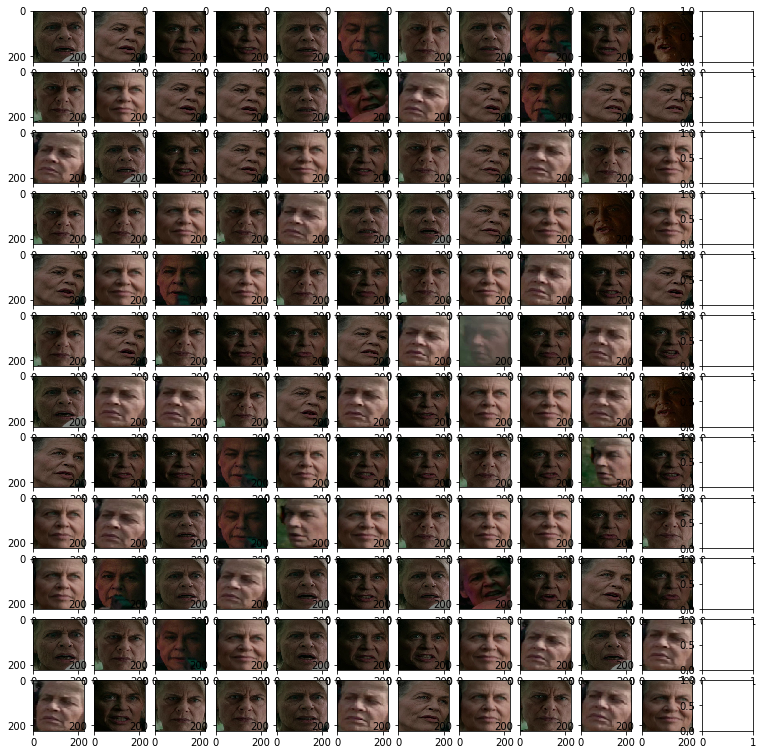

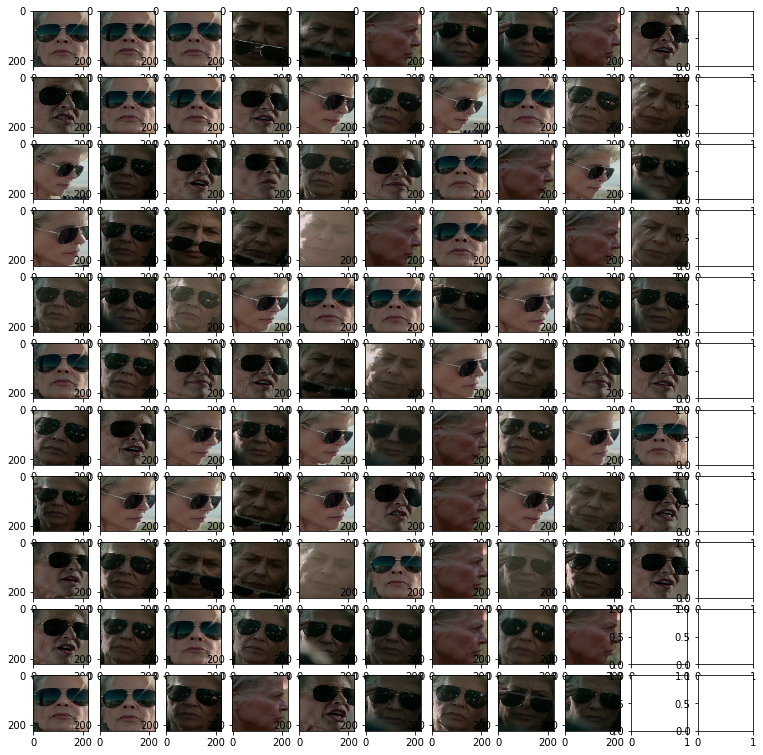

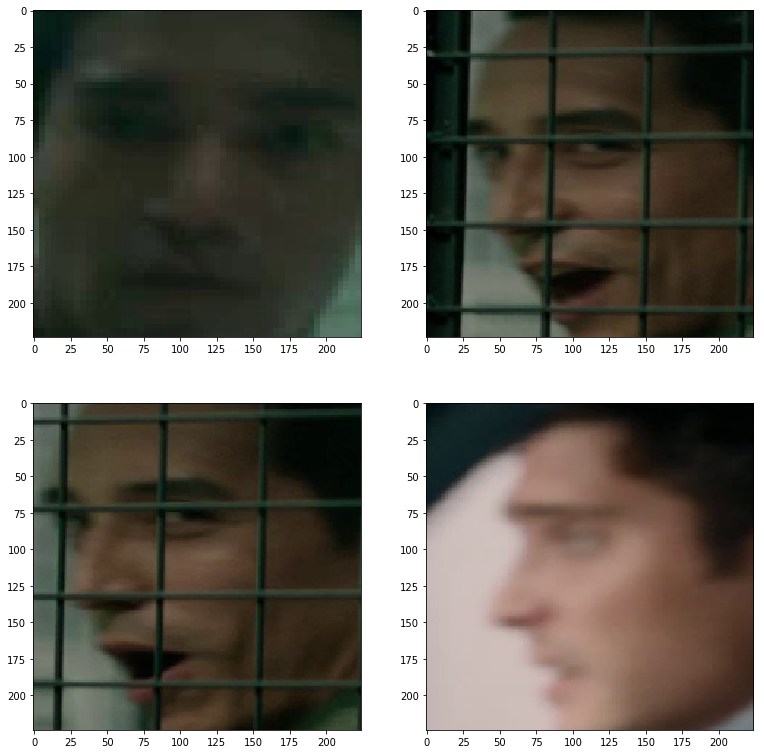

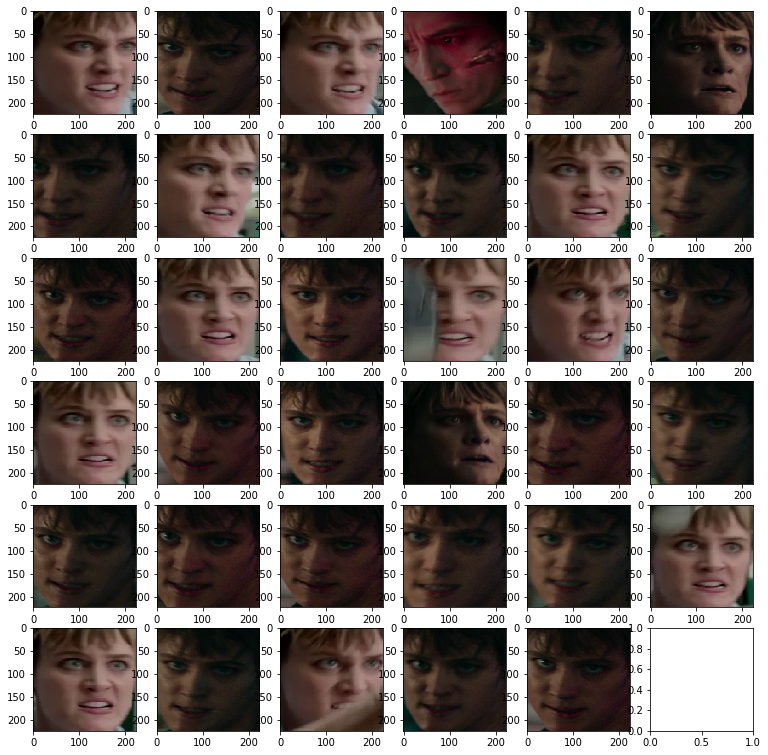

Error in callback <function flush_figures at 0x7f8183a6bc80> (for post_execute):


KeyboardInterrupt: ignored

In [41]:
def imageFilesToGrid(directory, outputFilename):
  filenames = glob.glob(directory+'/*.jpg')
  print(directory, ": ", len(filenames), " images")
  if len(filenames) < 4:
    return False
  result_figsize_resolution = 10 # 1 = 100px
  
  images_count = len(filenames)
  # Calculate the grid size:
  grid_size = math.ceil(math.sqrt(images_count))
  
  # Create plt plot:
  fig, axes = pyplot.subplots(grid_size, grid_size, figsize=(result_figsize_resolution, result_figsize_resolution))
  
  current_file_number = 0
  for image_filename in filenames:
      x_position = current_file_number % grid_size
      y_position = current_file_number // grid_size
      plt_image = pyplot.imread(image_filename)
      axes[x_position, y_position].imshow(plt_image)
      current_file_number += 1
  pyplot.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
  pyplot.savefig(outputFilename)
  #pyplot.show()

def exportImageGrids(directory):
  dirs = os.listdir(directory)
  dirs.sort()
  ndirs = len(dirs)
  for n,dir in enumerate(dirs):
    if dir is not "ALL":
      imageFilesToGrid(directory+"/"+dir, directory+"/"+dir+".jpg");
    progress(n, ndirs)

exportImageGrids("faces")